In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Loading the data
listings_dataframe = pd.read_csv("cleaned_listing_data.csv")
reviews_dataframe = pd.read_csv("reviews_summary.csv")

In [3]:
listings_dataframe.columns, reviews_dataframe.columns

(Index(['id', 'name', 'host_id', 'host_name', 'neighbourhood_group',
        'neighbourhood', 'latitude', 'longitude', 'room_type', 'price',
        'minimum_nights', 'number_of_reviews', 'reviews_per_month',
        'calculated_host_listings_count', 'availability_365',
        'number_of_reviews_ltm', 'reviewed'],
       dtype='object'),
 Index(['listing_id', 'date'], dtype='object'))

In [4]:
listings_dataframe.shape

(39638, 17)

# Questions to answer
1. What factors significantly influence the price of Airbnb listing in NYC?
2. How does the availability of Airbnb listings vary across different neighborhoods in NYC?
3. What is the relationship between number of reviews a listing has and its price/availability?
4. Do hosts with multiple listings price their properties differently compared to hosts with only one listing?
5. What is the distribution of different room types in the listings? Which type of room are mostly available? How do prices vary according to room type?
6. Is the current market preferring short-term rentals or long-term rentals?
7. Who are the top hosts and how many listings they have according to the room type?


## Distribution of price
First we will see how the distribution of price is

<Axes: xlabel='price', ylabel='Count'>

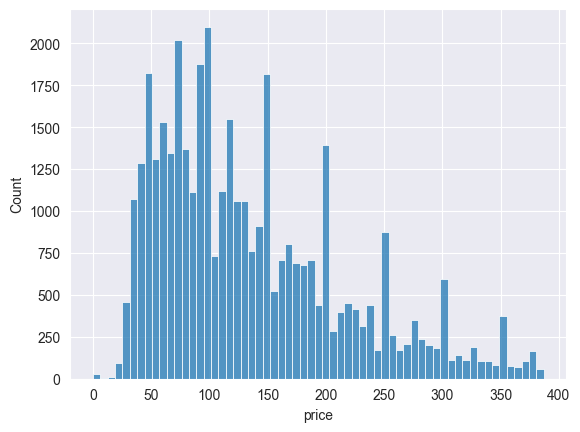

In [5]:
import numpy as np
sns.histplot(listings_dataframe,x='price')

<Axes: xlabel='price'>

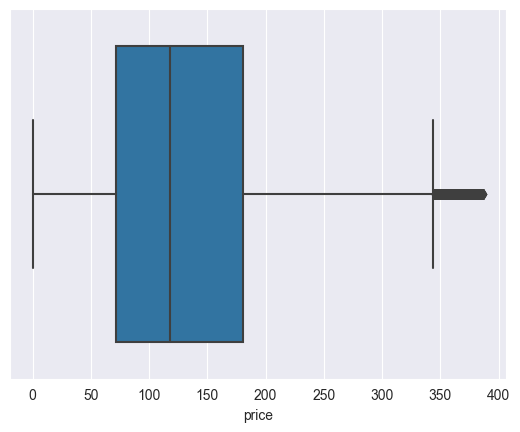

In [6]:
sns.boxplot(listings_dataframe,x="price")

There seems to be some right skewness in the dataset. But since the skewness isnt extreme, we dont necessarily need transformations.

## What factors significantly influence the price of Airbnb listing in NYC

Lets consider only the numerical variables first

<Axes: >

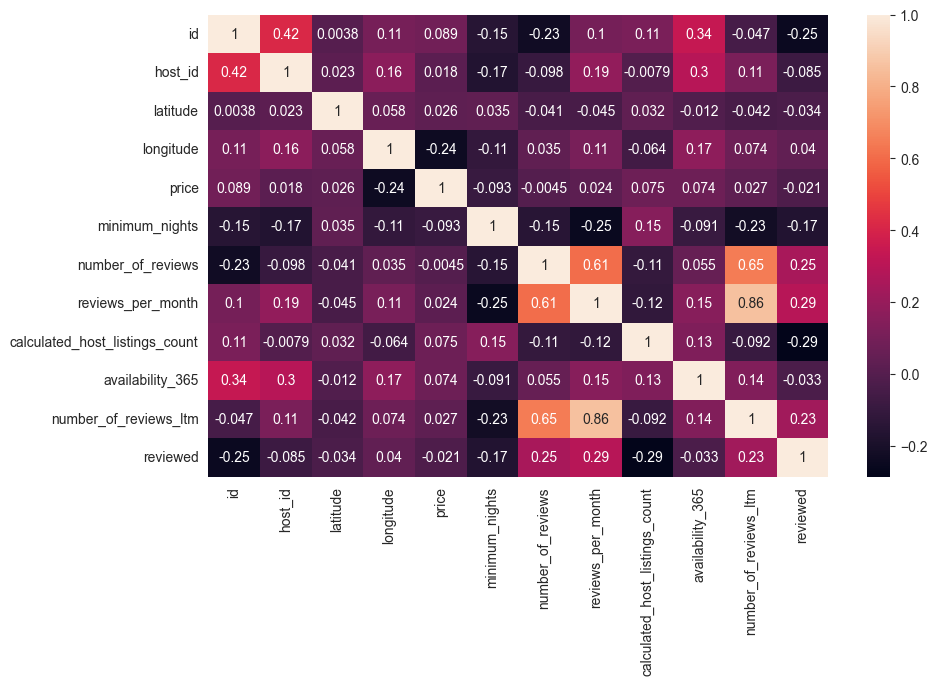

In [7]:
# selecting the numerical data
correlation_matrix = listings_dataframe.select_dtypes(include=[np.number]).corr()
plt.figure(figsize=(10,6))
sns.heatmap(correlation_matrix, annot=True)

In [8]:
correlation_with_price = correlation_matrix['price'].apply(abs)
sorted_corr_with_price = correlation_with_price.sort_values(ascending=False)

In [9]:
sorted_corr_with_price

price                             1.000000
longitude                         0.240760
minimum_nights                    0.093471
id                                0.088602
calculated_host_listings_count    0.075157
availability_365                  0.074112
number_of_reviews_ltm             0.026832
latitude                          0.025522
reviews_per_month                 0.023771
reviewed                          0.020950
host_id                           0.017930
number_of_reviews                 0.004511
Name: price, dtype: float64

There doesnt seem to be direct linear relationship between price and other variables. Visualizations can be used to reveal other interesting patterns and relationships

Text(0, 0.5, 'Price')

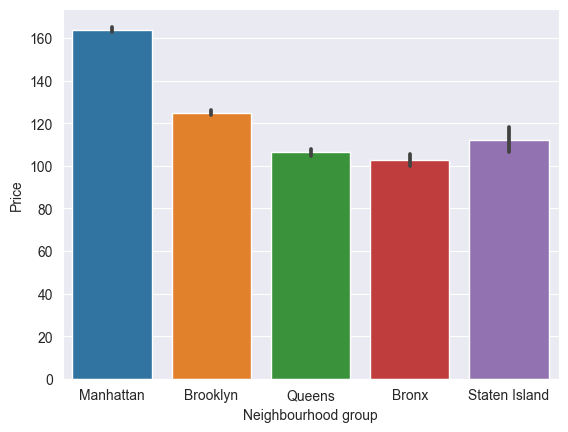

In [10]:
sns.barplot(listings_dataframe, x="neighbourhood_group", y="price")
plt.xlabel("Neighbourhood group")
plt.ylabel("Price")

From the barplot, it can be seen that the price in Manhattan area is significantly greater than other areas, so neighbourhood might be good feature to find out the price

Text(0, 0.5, 'Price')

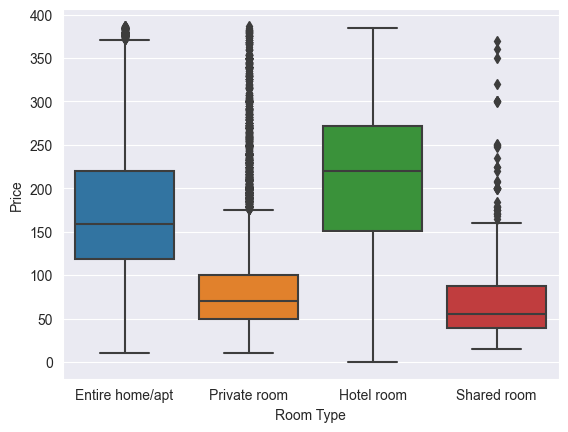

In [11]:
sns.boxplot(listings_dataframe, x="room_type", y="price")
plt.xlabel("Room Type")
plt.ylabel("Price")

The median prices for the room type are at different levels. This might help in finding the price of the listing. Thus, room_type can be considered a good factor for predicting price.

<Axes: xlabel='price', ylabel='availability_365'>

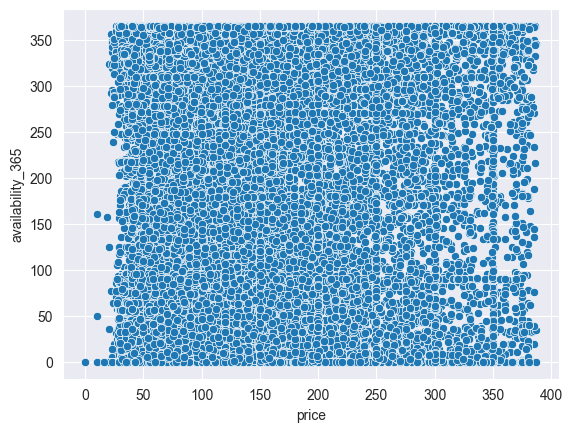

In [12]:
sns.scatterplot(listings_dataframe, x="price",y="availability_365")

The scatterplot have points scattered all across the plot, so there doesnt seem to be any specific relationship between price and availability.

<Axes: xlabel='calculated_host_listings_count', ylabel='price'>

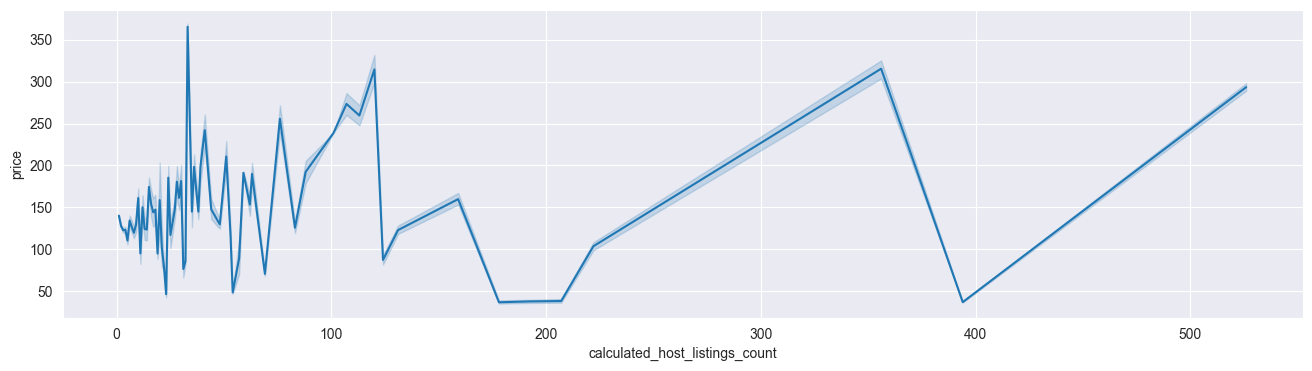

In [13]:
plt.figure(figsize=(16,4))
sns.lineplot(listings_dataframe, y="price",x="calculated_host_listings_count")

There seems to be some non-linear relationship between price and calculated_host_listings_count, so we might need to consider this variable to predict the price

From the above analysis, it can be noted that variables like calculated_host_listings_count, neighbourhood_group, room_type, etc. can be some factors that are important for pricing.

## How does the availability of Airbnb listings vary across different neighborhoods in NYC?

In [14]:
average_availability_by_neighbourhood  = listings_dataframe.groupby('neighbourhood_group').agg({"availability_365": 'mean'}).reset_index()

In [15]:
average_availability_by_neighbourhood

,neighbourhood_group,availability_365
0,Bronx,208.723660
1,Brooklyn,123.753896
2,Manhattan,125.336496
3,Queens,171.062519
4,Staten Island,211.121065


Text(0, 0.5, 'Availability (365 days)')

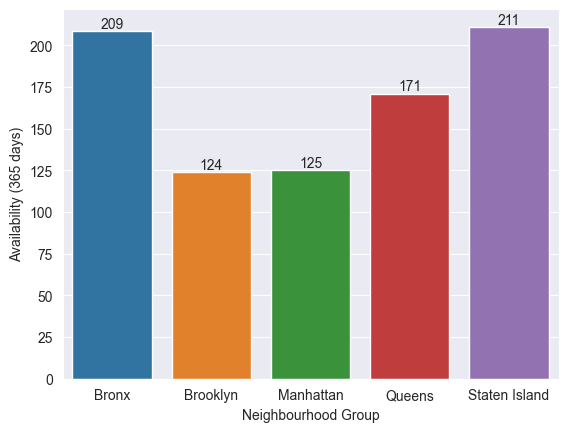

In [16]:
ax = sns.barplot(average_availability_by_neighbourhood,x="neighbourhood_group",y="availability_365")

# Add text values above the bars
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0, 5), textcoords = 'offset points')

# Set plot labels
ax.set_xlabel('Neighbourhood Group')
ax.set_ylabel('Availability (365 days)')

Staten Island had the highest average availability of 211 days, followed by Bronx with 209 days, Queens with 171 days, and Brooklyn and Manhattan had similar value of 124 and 125 respectively.

## What is the relationship between number of reviews a listing has and its price/availability?

In [17]:
merged_df = listings_dataframe.merge(reviews_dataframe, left_on="id", right_on="listing_id")

In [18]:
matching_counts = merged_df["id"].value_counts().reset_index()

In [19]:
matching_counts.columns = ["id","Number of Reviews"]

In [20]:
listings_dataframe_with_review_counts = listings_dataframe.merge(matching_counts, on="id", how="left")

In [21]:
listings_dataframe_with_review_counts["Number of Reviews"].fillna(0, inplace=True)

<Axes: xlabel='Number of Reviews', ylabel='price'>

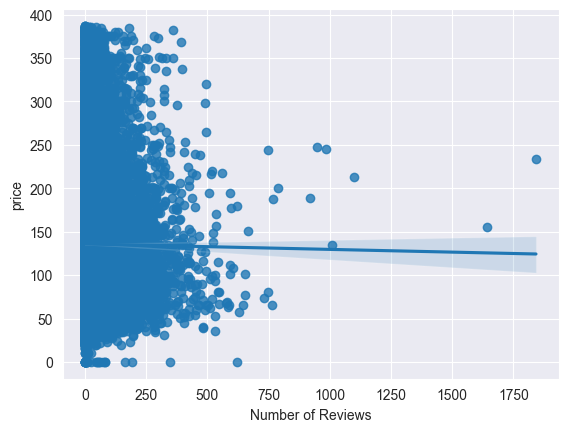

In [22]:
sns.regplot(data=listings_dataframe_with_review_counts, x="Number of Reviews", y="price")

<Axes: xlabel='Number of Reviews', ylabel='availability_365'>

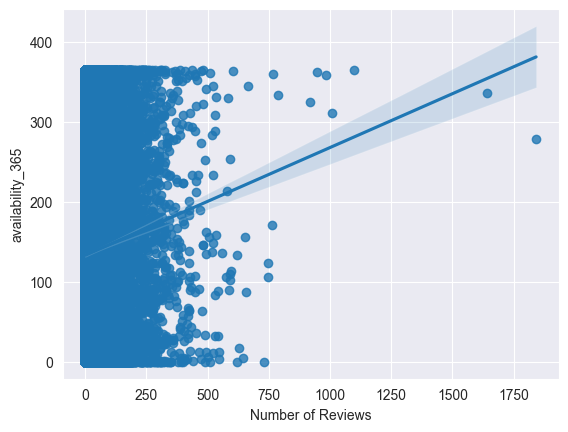

In [24]:
sns.regplot(data=listings_dataframe_with_review_counts, x="Number of Reviews", y="availability_365")


There doesnt seem to be any relationship between number of reviews and price/availability_365

## Do hosts with multiple listings price their properties differently compared to hosts with only one listing?

In [25]:
single_listing_host = listings_dataframe[listings_dataframe["calculated_host_listings_count"]==1]
multiple_listing_host = listings_dataframe[listings_dataframe["calculated_host_listings_count"]>1]

In [26]:
from scipy import stats

In [27]:
t_stat, p_val = stats.ttest_ind(single_listing_host['price'], multiple_listing_host['price'])
print(f"T-statistic: {t_stat}, p-value: {p_val}")

T-statistic: 11.826782621594447, p-value: 3.215592935582048e-32


The p-value of p-value: 3.215592935582048e-32 which is less than 0.05, indicates that there is a statistically significant difference in the average prices between hosts with multiple listings and hosts with only one listing. Statistically significant here mean that the observed effect in the data is unlikely to have occured by chance, given a predifined level of probabiblity, called significance level which is generally 0.05(5%)


In [28]:
listings_dataframe['multiple_listings'] = listings_dataframe['calculated_host_listings_count'] > 1

In [29]:
average_prices = listings_dataframe.groupby('multiple_listings')['price'].mean()
print(average_prices)

multiple_listings
False    140.242494
True     130.667238
Name: price, dtype: float64


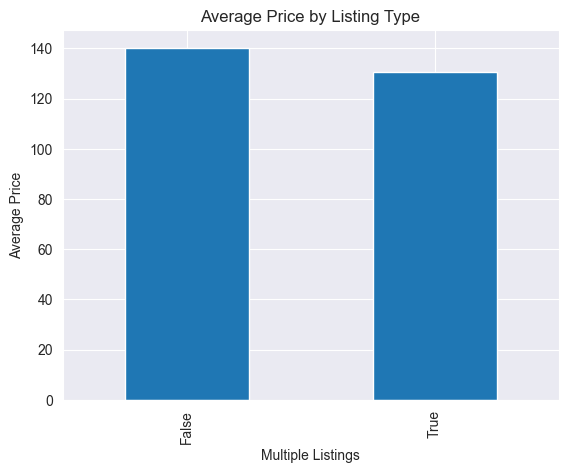

In [30]:
average_prices.plot(kind='bar')
plt.xlabel('Multiple Listings')
plt.ylabel('Average Price')
plt.title('Average Price by Listing Type')
plt.show()

It can be seen that hosts with multiple listings have average price of about 130 while, hosts with single listing have price of about 140. This might be due to the fact that people with more listing have much more experience regarding how the rent price should be.

From this it can be concluded that hosts with multiple listings price their properties differently as compared to hosts with single listing.

## What is the distribution of different room types in the listings? Which type of room are mostly available?
Airbnb have 4 types of rooms:
* Entire home/apt
* Private room
* Shared room
* Hotel room
We want to find which type of rom are listed the most and are mostly available

In [36]:
data_grouped_by_room_type = listings_dataframe.groupby('room_type').agg({'room_type':'count','availability_365':'mean', 'price':'mean'}).rename(columns={'room_type': 'count', 'availability_365': 'average_availability','price':'average_price'}).reset_index()
data_grouped_by_room_type['percentage'] = round(data_grouped_by_room_type['count']/data_grouped_by_room_type['count'].sum()*100,2)


In [37]:
# Sorting in descending order by percentage
data_grouped_by_room_type = data_grouped_by_room_type.sort_values('percentage',ascending=False).reset_index()

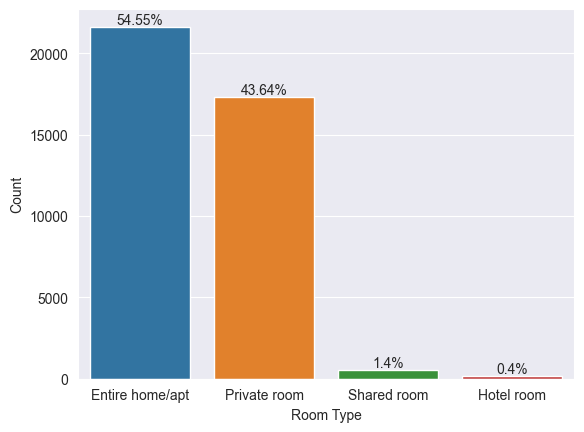

In [39]:
# plotting barplot with room type and count
ax = sns.barplot(data_grouped_by_room_type,x="room_type",y="count")
plt.xlabel("Room Type")
plt.ylabel("Count")
for i in range(data_grouped_by_room_type.shape[0]):
    percentage = data_grouped_by_room_type["percentage"][i]
    room_type = data_grouped_by_room_type['room_type'][i]
    count = data_grouped_by_room_type["count"][i]
    ax.annotate(f'{percentage}%', (i, count), ha='center', va='bottom')



Entire home/apt are the most listed room type in NYC with 54.55%, followed by Private room with 43.64%, with shared room and hotel room have significantly low with 1.4% and 0.4% respectively.

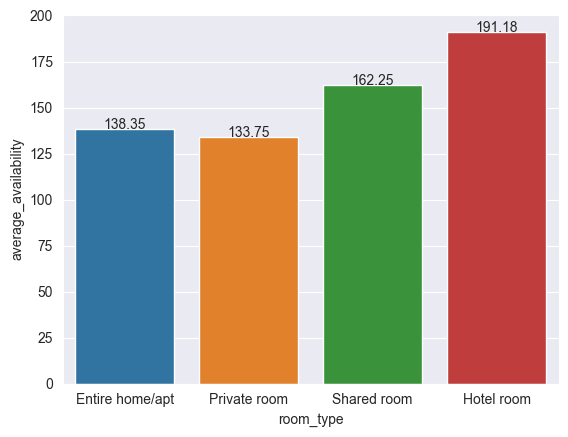

In [40]:
# plotting barplot with room type and count
ax = sns.barplot(data_grouped_by_room_type,x="room_type",y="average_availability")
# Add the text on top of each bar
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # Adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2),  # x-coordinate position of data label, positioned at the middle of the bar
            y = height,  # y-coordinate position of data label, positioned above the bar
            s = '{:.2f}'.format(height),  # data label, formatted to ignore decimals
            ha = 'center')  # sets horizontal alignment (ha) to center

Text(0, 0.5, 'Average Price')

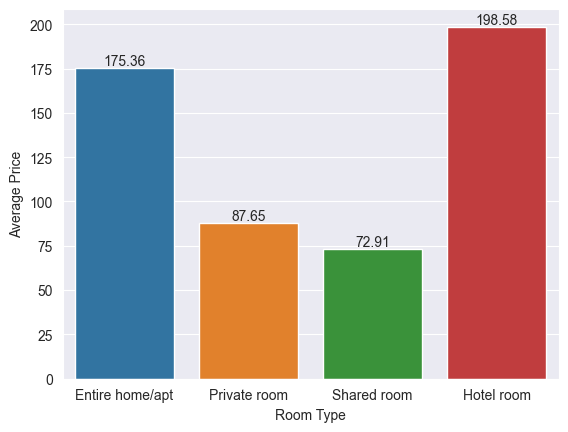

In [44]:
# plotting barplot with room type and count
ax = sns.barplot(data_grouped_by_room_type,x="room_type",y="average_price")
# Add the text on top of each bar
for p in ax.patches:
    height = p.get_height()  # get the height of each bar
    # Adding text to each bar
    ax.text(x = p.get_x()+(p.get_width()/2),  # x-coordinate position of data label, positioned at the middle of the bar
            y = height,  # y-coordinate position of data label, positioned above the bar
            s = '{:.2f}'.format(height),  # data label, formatted to ignore decimals
            ha = 'center',
            va="bottom"
            )  # sets horizontal alignment (ha) to center
plt.xlabel("Room Type")
plt.ylabel("Average Price")

The availability(in days) seems to be the most for hotel room with 191.18, followed by 162.25, entire home/apt with 138.35 and private room with 133.75

The most expensive listings seems to be that of hotel room with 198.58$, followed by entire home/apt 175.36$, private room with 87.65$ and shared room with 72.91$.

## Is the current market preferring short-term rentals or long-term rentals?
* Short-term rentals: Renting properties with less than 30 nights minimum stay.
* Long-term rentals: Renting properties with more than 30 nights minimum stay.

In [34]:
# calculating if the listings are short-term rentals or long-term rentals
# 1 = short-term
# 0 = long-term
listings_dataframe['rental_type'] = (listings_dataframe['minimum_nights'] < 30).astype(int)


In [35]:
total_short_term_rentals = listings_dataframe['rental_type'].sum()
total_long_term_rentals = listings_dataframe.shape[0] - total_short_term_rentals

In [36]:
data = pd.DataFrame({'Rental Type': ['Short Term', 'Long Term'],
                     'Count': [total_short_term_rentals, total_long_term_rentals]})


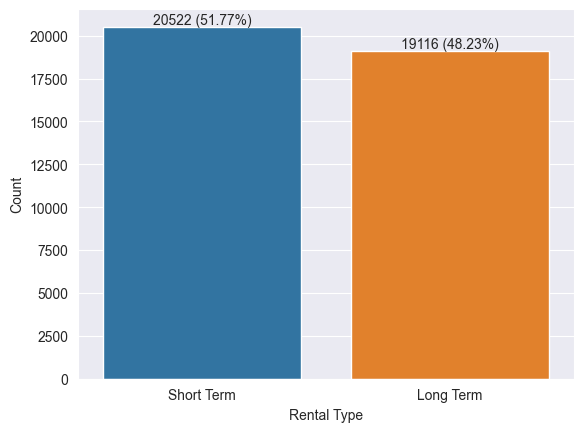

In [37]:
ax = sns.barplot(data,x="Rental Type",y="Count")
for p in ax.patches:
    percentage = round(p.get_height()/listings_dataframe.shape[0]*100,2)
    ax.annotate(f'{int(p.get_height())} ({percentage}%)',
                (p.get_x()+p.get_width()/2,p.get_height()),
                ha="center", va="bottom"
                )

We can see that the current market is favoring Short-Term rental as compared to long-term even though the regulations for short term are stricter in NYC. This may be due to the following factors:
* Short term rentals are favoured by the travellers visiting for short time.
* There are large number of private rooms for rent, where owners might want to gain financial benefits on short-term.
* Rent Control and Rent Stabilization laws apply to long-term rentals to protect tenants by controlling rent increases. These laws don't apply to short-term rentals

## Who are the top hosts and how many listings they have according to the room type?
Top hosts are determined by the total number of listing they have.

In [49]:
data_grouped_by_host_room_type = listings_dataframe.groupby(['host_id','room_type']).size().reset_index(name="Listings Count")

In [50]:
pivot_table = data_grouped_by_host_room_type.pivot(index="host_id", columns="room_type", values="Listings Count")

In [51]:
pivot_table.fillna(0, inplace=True)

In [52]:
pivot_table['Total'] = pivot_table.sum(axis=1)

In [53]:
pivot_table.columns.name = None
pivot_table.reset_index(inplace=True)
pivot_table.columns = ['host_id', 'Entire home/apts', 'Private rooms', 'Shared rooms', 'Hotel Rooms', 'Total Listings']


In [54]:
pivot_table.sort_values("Total Listings", ascending=False, inplace=True)

In [55]:
pivot_table = pivot_table.reset_index(drop=True)

In [56]:
top_hosts = pivot_table[pivot_table.columns[pivot_table.columns != 'index']]

In [57]:
top_hosts["Entire home/apts"] = top_hosts["Entire home/apts"].astype(int)
top_hosts["Private rooms"] = top_hosts["Private rooms"].astype(int)
top_hosts["Shared rooms"] = top_hosts["Shared rooms"].astype(int)
top_hosts["Hotel Rooms"] = top_hosts["Hotel Rooms"].astype(int)
top_hosts["Total Listings"] = top_hosts["Total Listings"].astype(int)

In [58]:
top_hosts

,host_id,Entire home/apts,Private rooms,Shared rooms,Hotel Rooms,Total Listings
0,107434423,415,0,0,0,415
1,3223938,0,0,394,0,394
2,305240193,30,0,192,0,222
3,19303369,9,0,198,0,207
4,200239515,5,0,187,0,192
...,...,...,...,...,...,...
25771,22805880,1,0,0,0,1
25772,22805576,0,0,1,0,1
25773,22792227,0,0,1,0,1
25774,22781364,1,0,0,0,1


In [59]:
top_hosts.to_csv('host_room_type_pivot_table.csv',index=False, encoding='utf-8')